In [56]:
# For Path handling
from pathlib import Path

# For General Data Wrangling and Calculations
import pandas as pd
import numpy as np

# For loading data
from scipy.sparse import load_npz

# For setting random seed
import random

# For Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns

# FOr calculating metrics
from sklearn.metrics import classification_report

# RANDOM FOREST CLASSIFIER MODEL
To perform the Medical Abstract Text Classification, we will apply a Random Forest Classifier. A Random Forest Classifier is an ensembled method that combines multiple decision trees outputs to reach a single result.

To start, we will first load the raw data and vectorized text created in the step 1.

In [28]:
# Train data path
train_df = Path("../data/Raw/medical_tc_train.csv")
# Test data path
test_df = Path("../data/Raw/medical_tc_test.csv")
# Labels path
labels_df = Path("../data/Raw/medical_tc_labels.csv")

# TF-IDF
tfidf_train = Path("../data/Processed/train_lemma_tfidf.npz")
tfidf_test = Path("../data/Processed/test_lemma_tfidf.npz")

# BioSent2Vec
s2v_train = Path("../data/Processed/train_lemma_s2v.npy")
s2v_test = Path("../data/Processed/test_lemma_s2v.npy")

# Open Raw Data
train_df = pd.read_csv(train_df)
test_df = pd.read_csv(test_df)
labels_df = pd.read_csv(labels_df)
# Add Labels to Training and Testing sets
train_df = pd.merge(train_df,labels_df, how = "left", on = "condition_label")
test_df = pd.merge(test_df,labels_df, how = "left", on = "condition_label")

# Open TF-IDF data
tfidf_train = load_npz(tfidf_train)
tfidf_test = load_npz(tfidf_test)

# Open BioSent2Vec data
s2v_train = np.load(s2v_train, allow_pickle = True)
s2v_test = np.load(s2v_test, allow_pickle = True)

Define the Random Forest Classifier and set random state for reproducibility.

In [35]:
# All parameters not specified are set to their defaults
clf_tfidf = RandomForestClassifier(n_estimators = 200, random_state = random.seed(777))
clf_s2v = RandomForestClassifier(n_estimators = 200, random_state = random.seed(777))
# It is important to set a random state to make results reproducible

Train Random Forest Classifiers uisng the trainning vectorized data.

In [36]:
# Model training using the train dataset and the two vectorization methods
clf_tfidf.fit(tfidf_train, train_df["condition_label"]) # TF-IDF
clf_s2v.fit(s2v_train, train_df["condition_label"]) # BioSent2Vec

RandomForestClassifier(n_estimators=200)

## Assess models performance
We will use Accuracy, Precision, Recall and F1-score to assess the model performance for the two different vectorization methods.

First, we will predict the test data classes using the fitted models.

In [40]:
pred_tfidf = clf_tfidf.predict(tfidf_test)
pred_s2v = clf_s2v.predict(s2v_test)

Define function to calculate all model metrics

In [46]:
def calculate_model_metrics(y_test, y_pred, vec_method):
    # Import functions
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

    metrics_dict = dict()
    
    # Accuracy
    metrics_dict["accuracy"] = accuracy_score(y_test, y_pred)

    # Precision
    metrics_dict["precision"] = precision_score(y_test, y_pred, average='weighted')  # or 'macro', 'micro'

    # Recall
    metrics_dict["recall"] = recall_score(y_test, y_pred, average='weighted')

    # F1 Score
    metrics_dict["f1"] = f1_score(y_test, y_pred, average='weighted')

    # Print results
    print(f"\n--- Random Forest Classifier with {vec_method} vectorization method ---")
    print(f"Accuracy: {metrics_dict["accuracy"]:.4f}")
    print(f"Precision: {metrics_dict["precision"]:.4f}")
    print(f"Recall: {metrics_dict["recall"]:.4f}")
    print(f"F1-score: {metrics_dict["f1"]:.4f}")

    return metrics_dict

Calculate metrics for both vectorization models

In [47]:
# TF-IDF vectorization method
tfidf_metrics = calculate_model_metrics(test_df["condition_label"], pred_tfidf, "TF-IDF")
# TF-IDF vectorization method
s2v_metrics = calculate_model_metrics(test_df["condition_label"], pred_s2v, "BioSentence2Vec")


--- Random Forest Classifier with TF-IDF vectorization method ---
Accuracy: 0.2015
Precision: 0.1981
Recall: 0.2015
F1-score: 0.1996

--- Random Forest Classifier with BioSentence2Vec vectorization method ---
Accuracy: 0.4287
Precision: 0.4291
Recall: 0.4287
F1-score: 0.4217


### Confusion Matrix for Random Forest Classifier using TF-IDF vectorization method

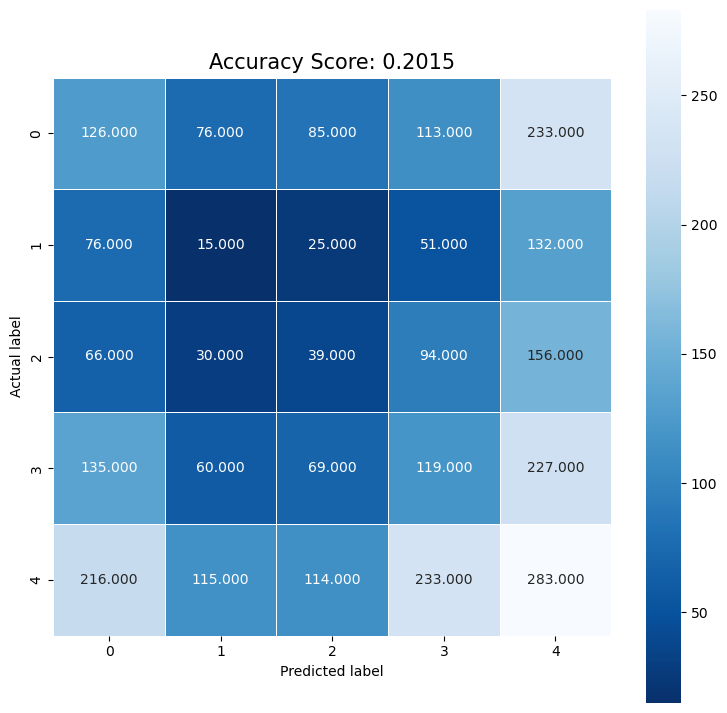

In [52]:
cm = metrics.confusion_matrix(test_df["condition_label"], pred_tfidf)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(round(tfidf_metrics["accuracy"], 4))
plt.title(all_sample_title, size = 15);
plt.savefig("../plots/cm_tfidf.png")
plt.show()

### Confusion Matrix for Random Forest Classifier using BioSent2Vec vectorization method

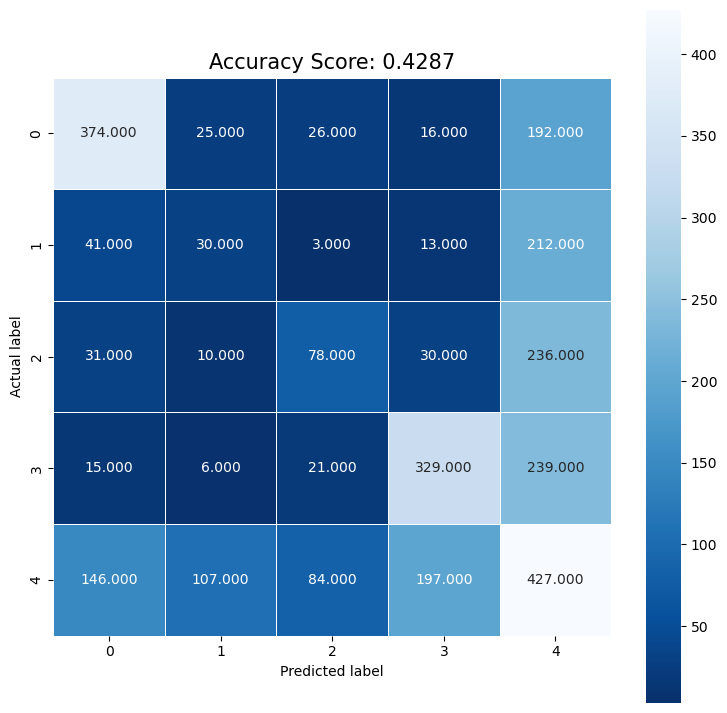

In [60]:
cm = metrics.confusion_matrix(test_df["condition_label"], pred_s2v)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(round(s2v_metrics["accuracy"], 4))
plt.title(all_sample_title, size = 15);
plt.savefig("../plots/cm_s2v.png")
plt.show()

### Classification report
For TF-IDF vectorization method

In [58]:
print(classification_report(test_df["condition_label"], pred_tfidf))

              precision    recall  f1-score   support

           1       0.20      0.20      0.20       633
           2       0.05      0.05      0.05       299
           3       0.12      0.10      0.11       385
           4       0.20      0.20      0.20       610
           5       0.27      0.29      0.28       961

    accuracy                           0.20      2888
   macro avg       0.17      0.17      0.17      2888
weighted avg       0.20      0.20      0.20      2888



For BioSent2VEc vectorization method

In [59]:
print(classification_report(test_df["condition_label"], pred_s2v))

              precision    recall  f1-score   support

           1       0.62      0.59      0.60       633
           2       0.17      0.10      0.13       299
           3       0.37      0.20      0.26       385
           4       0.56      0.54      0.55       610
           5       0.33      0.44      0.38       961

    accuracy                           0.43      2888
   macro avg       0.41      0.38      0.38      2888
weighted avg       0.43      0.43      0.42      2888

